In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [3]:
from dataset import CANDatasetStandard
from dataset import CANDatasetEnet as CANDataset
import torch
from torchvision import transforms
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda")

In [5]:
can_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_dataset = CANDataset(root_dir='../data/can-ml/2017-subaru-forester/preprocessed/size_64_10/TFRecord_w64_s32/2', window_size=32, is_train=False, transform=can_transform)
# test_dataset = CANDataset(root_dir='../data/can-ml/2017-subaru-forester/preprocessed/size_64_10_baseline/TFRecord_w64_s32/2', window_size=32, is_train=False, transform=can_transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [7]:
from networks.resnet_big import ConResNet
from networks.efficient_net import ConEfficientNet, LinearClassifier
# from networks.resnet_big import LinearClassifier

# model = ConResNet('resnet50')
# classifier = LinearClassifier(num_classes=10)

model = ConEfficientNet(embedding_dim=1792, feat_dim=128, head='mlp', pretrained=False)
classifier = LinearClassifier(input_dim=1792, num_classes=10)

In [8]:
save_path = '../save/CAN-ML_models/UniCon/UniCon_CAN-ML_efficient-net_lr_0.05_decay_0.0001_bsz_64_temp_0.07_mixup_lambda_0.5_trial_can_ml_con_enet_b4_64_cosine_warm'
ckpt_epoch = 158
# save_path = '../save/CAN-ML_models/UniCon/UniCon_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_64_temp_0.07_mixup_lambda_0.5_trial_can_ml_uni_resnet_cosine_warm/'
# ckpt_epoch = 37
model_path = f'{save_path}/last.pth'
model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [9]:
class_model_path = f'{save_path}/ckpt_class_epoch_{ckpt_epoch}.pth'
# class_model_path = f'{save_path}/last.pth'
ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [10]:
import numpy as np
import tqdm
total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)
total_embs = np.empty(shape=(0, 1792), dtype=float)
# total_embs = np.empty(shape=(0, 2048), dtype=float)

model = model.cuda()
classifier = classifier.cuda()
model.eval()
classifier.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.cuda(non_blocking=True)
        embs = model.encoder(images)
        outputs = classifier(embs)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t().cpu().numpy().squeeze(0)
        embs = embs.cpu().numpy()

        total_embs = np.concatenate((total_embs, embs), axis=0)
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)
# After the loop, total_pred, total_label, and total_embs will have accumulated data


100%|██████████| 410/410 [00:47<00:00,  8.72it/s]


In [11]:
from sklearn.metrics import confusion_matrix

def cal_metric(label, pred):
    cm = confusion_matrix(label, pred)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    precision[np.isnan(precision)] = 0  # Handle NaN values in precision
    
    f1 = 2 * recall * precision / (recall + precision)
    f1[np.isnan(f1)] = 0  # Handle NaN values in F1 score
    
    total_actual = np.sum(cm, axis=1)
    true_predicted = np.diag(cm)
    fnr = (total_actual - true_predicted) * 100 / total_actual
    
    return cm, {
        'fnr': np.array(fnr),
        'rec': recall,
        'pre': precision,
        'f1': f1
    }

In [12]:
def print_metrics_horizontal(metrics, class_names):
    # Determine the maximum width for class names for proper alignment
    max_name_len = max(len(name) for name in class_names) + 2  # Extra padding
    
    # Print header with class names aligned
    header = f"{'Metric':<6} | " + " | ".join([f"{name:<{max_name_len}}" for name in class_names])
    print(header)
    print("-" * (8 + len(class_names) * (max_name_len + 2)))
    
    # Print each metric's values for all classes
    for key, values in metrics.items():
        row = f"{key.upper():<6} | " + " | ".join([f"{value:<{max_name_len}.4f}" for value in values])
        print(row)

In [13]:
classes = ['Normal', 'Combined', 'DoS', 'Fuzzing', 'Gear','Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_classes = len(classes)

In [14]:
cm, results = cal_metric(total_label, total_pred)
print_metrics_horizontal(results, classes)

Metric | Normal       | Combined     | DoS          | Fuzzing      | Gear         | Interval     | RPM          | Speed        | Standstill   | Systematic  
----------------------------------------------------------------------------------------------------------------------------------------------------
FNR    | 0.0477       | 0.2281       | 0.0000       | 4.3307       | 1.4151       | 0.0000       | 1.0025       | 0.4175       | 1.0753       | 1.0453      
REC    | 0.9995       | 0.9977       | 1.0000       | 0.9567       | 0.9858       | 1.0000       | 0.9900       | 0.9958       | 0.9892       | 0.9895      
PRE    | 0.9988       | 0.9954       | 1.0000       | 1.0000       | 1.0000       | 1.0000       | 1.0000       | 0.9979       | 1.0000       | 0.9827      
F1     | 0.9991       | 0.9966       | 1.0000       | 0.9779       | 0.9929       | 1.0000       | 0.9950       | 0.9969       | 0.9946       | 0.9861      


In [15]:
from sklearn.metrics import classification_report


target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(total_label, total_pred, target_names=target_names, digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Normal     0.9988    0.9995    0.9991     20973
    Combined     0.9954    0.9977    0.9966      1315
         DoS     1.0000    1.0000    1.0000       201
       Fuzzy     1.0000    0.9567    0.9779       254
        Gear     1.0000    0.9858    0.9929       212
    Interval     1.0000    1.0000    1.0000      1909
         RPM     1.0000    0.9900    0.9950       399
       Speed     0.9979    0.9958    0.9969       479
  Standstill     1.0000    0.9892    0.9946       186
  Systematic     0.9827    0.9895    0.9861       287

    accuracy                         0.9986     26215
   macro avg     0.9975    0.9904    0.9939     26215
weighted avg     0.9986    0.9986    0.9985     26215



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def draw_confusion_matrix(cm, classes, save_dir=None):
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    mask = np.zeros_like(cm)
    np.fill_diagonal(mask, 1)
    plt.figure(figsize=(10,8))
    # sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5)
    sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, 
            linewidths=0.5, vmin=0, vmax=2500,)
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    if save_dir is not None:
        plt.savefig(save_dir.format(ckpt_epoch), dpi=300, bbox_inches="tight", pad_inches=0.5)
    plt.show()

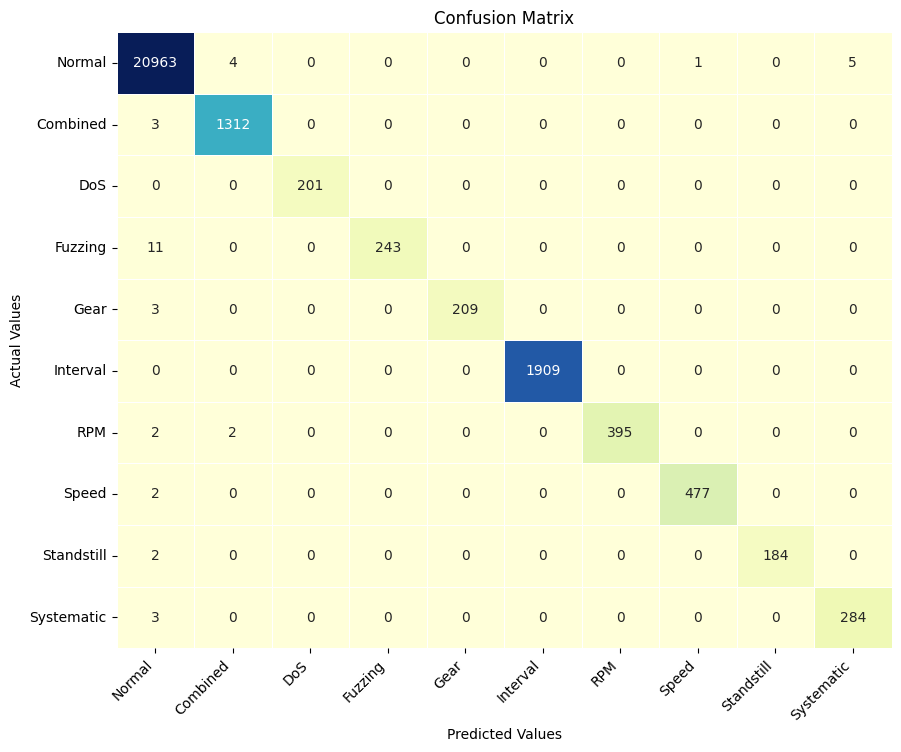

In [17]:
# draw_confusion_matrix(cm, classes, save_dir='../pic/conf_matrix/confusion_matrix_unicon_resnet_can_ml_{}.png')
draw_confusion_matrix(cm, classes)

In [18]:
# np.random.seed(100)
# indices = np.empty(shape=(0), dtype=int)
# num_samples = 1000
# for c in range(n_classes):
#     idx_c = np.where(total_label==c)[0]
#     idx_c = np.random.choice(idx_c, num_samples, replace=True)
#     indices = np.concatenate((indices, idx_c), axis=0)

np.random.seed(100)

# Chọn số lượng mẫu cho mỗi lớp (giả định tất cả đều bằng nhau)
num_samples = 1000
indices = np.empty(shape=(0), dtype=int)
for c in range(n_classes):
    idx_c = np.where(total_label == c)[0]
    if len(idx_c) == 0:
        print(f"Warning: No samples found for class {c}.")
        continue
    idx_c = np.random.choice(idx_c, num_samples, replace=True)
    indices = np.concatenate((indices, idx_c), axis=0)


In [19]:
total_embs[indices] /= 10**2
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(total_embs[indices])

In [41]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1, perplexity=60)
new_embs = tsne.fit_transform(total_embs[indices])

In [49]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None, save_dir=None):
    plt.figure(figsize=(12,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)
    if save_dir is not None:
        plt.savefig(save_dir.format(ckpt_epoch), dpi=300)

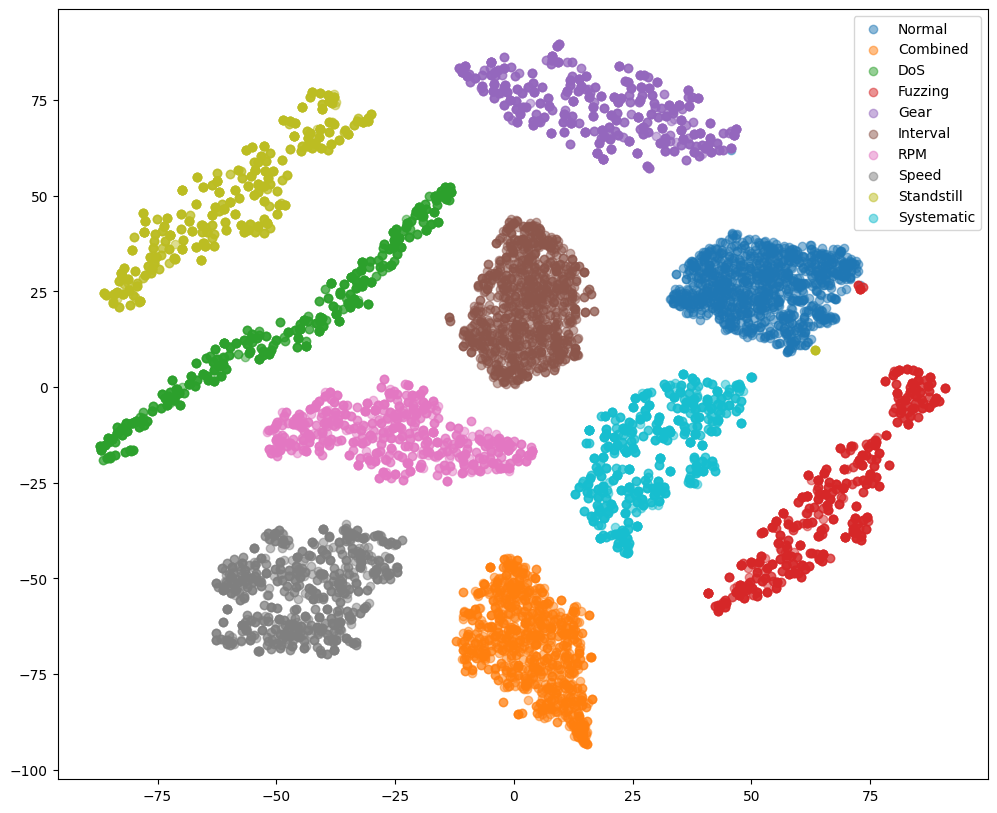

In [50]:
# plot_embeddings(new_embs, total_label[indices], save_dir='../pic/tsne/tsne_unicon_resnet_can_ml_{}.png')
plot_embeddings(new_embs, total_label[indices])

In [44]:
import random
def get_universum(images, labels, opt):
    """Calculating Mixup-induced universum from a batch of images"""
    device = torch.device("cuda")

    tmp = images.cpu()
    label = labels.cpu()
    bsz = tmp.shape[0]
    bs = len(label)
# Create a dictionary for class_images instead of list
    class_images = {int(i): [] for i in label.unique()}
    for i in label.unique():
        # Collect indices where label != i
        other_indices = torch.where(label != i)[0].tolist()
        if other_indices:  # Ensure non-empty entries
            class_images[int(i)] = other_indices

    units = []
    for i in range(bsz):
        target_label = int(labels[i % bs])  # Current target label
        if class_images[target_label]:  # If valid class images exist
            chosen_index = random.choice(class_images[target_label])
            units.append(tmp[chosen_index])
        else:
            # Fallback: Use the original image if no other class images are available
            units.append(tmp[i % bs])
    universum = torch.stack(units, dim=0).to(device)

    lamda = opt.lamda
    if not hasattr(opt, 'mix') or opt.mix == 'mixup':
        # Using Mixup
        universum = lamda * universum + (1 - lamda) * images
    return universum

In [53]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import tqdm
from types import SimpleNamespace

opt_dict = {
    'lamda': 0.5,
    'mix': 'mixup',
    'device': 'cuda',
    'method': 'UniCon'
}

# Chuyển dict thành object
opt = SimpleNamespace(**opt_dict)
total_universum = np.empty(shape=(0, 1792), dtype=float)  # Thêm cho Universum embeddings

model = model.to(device)
classifier = classifier.to(device)
model.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        # Chuyển images và labels sang device
        
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Gọi hàm get_universum để lấy Universum embeddings
        universum_images = get_universum(images, labels, opt)
        universum_embs = model.encoder(universum_images).cpu().numpy()

        # Lưu kết quả
        total_universum = np.concatenate((total_universum, universum_embs), axis=0)

# In ra thông tin để kiểm tra
print("Total Universum shape:", total_universum.shape)


100%|██████████| 410/410 [00:47<00:00,  8.71it/s]

Total Universum shape: (26215, 1792)


In [46]:
universum_scaled = scaler.fit_transform(total_universum[indices])  # Sử dụng scaler đã fit trước đó
universum_tsne = tsne.fit_transform(universum_scaled)  # Dùng t-SNE trên Universum riêng biệt

In [51]:
# def plot_tsne_with_universum(embeddings, targets, universum_embeddings, n_classes):
#     plt.figure(figsize=(10, 10))
#     colors = plt.cm.tab10(np.linspace(0, 1, n_classes))  # Màu sắc cho các lớp

#     # Vẽ các lớp chính
#     for i in range(n_classes):
#         inds = np.where(targets == i)[0]
#         plt.scatter(embeddings[inds, 0], embeddings[inds, 1], 
#                     alpha=0.5, color=colors[i], label=f"Class {i}", s=20)

#     # Vẽ Universum
#     plt.scatter(universum_embeddings[:, 0], universum_embeddings[:, 1], 
#                 color='#555555', alpha=0.3, label="Universum", s=30, marker='^')

#     plt.title("t-SNE Visualization with Universum")
#     plt.xlabel("t-SNE Dimension 1")
#     plt.ylabel("t-SNE Dimension 2")
#     plt.legend()
#     plt.show()
from sklearn.metrics import pairwise_distances

def assign_universum_colors(tsne_universum, tsne_embeddings, labels, n_classes):
    universum_colors = []
    class_colors = plt.cm.tab10(np.linspace(0, 1, n_classes))  # Màu của từng lớp

    # Tính khoảng cách của Universum đến các điểm trong từng lớp
    for u_point in tsne_universum:
        distances = pairwise_distances([u_point], tsne_embeddings)  # Khoảng cách tới tất cả điểm
        nearest_label = labels[np.argmin(distances)]  # Lấy nhãn gần nhất
        universum_colors.append(class_colors[nearest_label])  # Gán màu tương ứng

    return universum_colors

# Gọi hàm để gán màu cho Universum
universum_colors = assign_universum_colors(universum_tsne, new_embs, total_label[indices], n_classes)

# Vẽ lại biểu đồ
def plot_tsne_with_colored_universum(tsne_embeddings, targets, universum_embeddings, universum_colors, n_classes):
    plt.figure(figsize=(12, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))  # Màu sắc cho các lớp chính

    # Vẽ các lớp chính
    for i in range(n_classes):
        inds = np.where(targets == i)[0]
        plt.scatter(tsne_embeddings[inds, 0], tsne_embeddings[inds, 1],
                    alpha=0.5, color=colors[i], label=f"Class {i}", s=20)

    # Vẽ Universum với màu tương ứng
    plt.scatter(universum_embeddings[:, 0], universum_embeddings[:, 1],
                c='lime', alpha=0.3, s=10, marker='^', label="Universum")

    plt.title("t-SNE Visualization with Colored Universum")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(classes)
    plt.show()



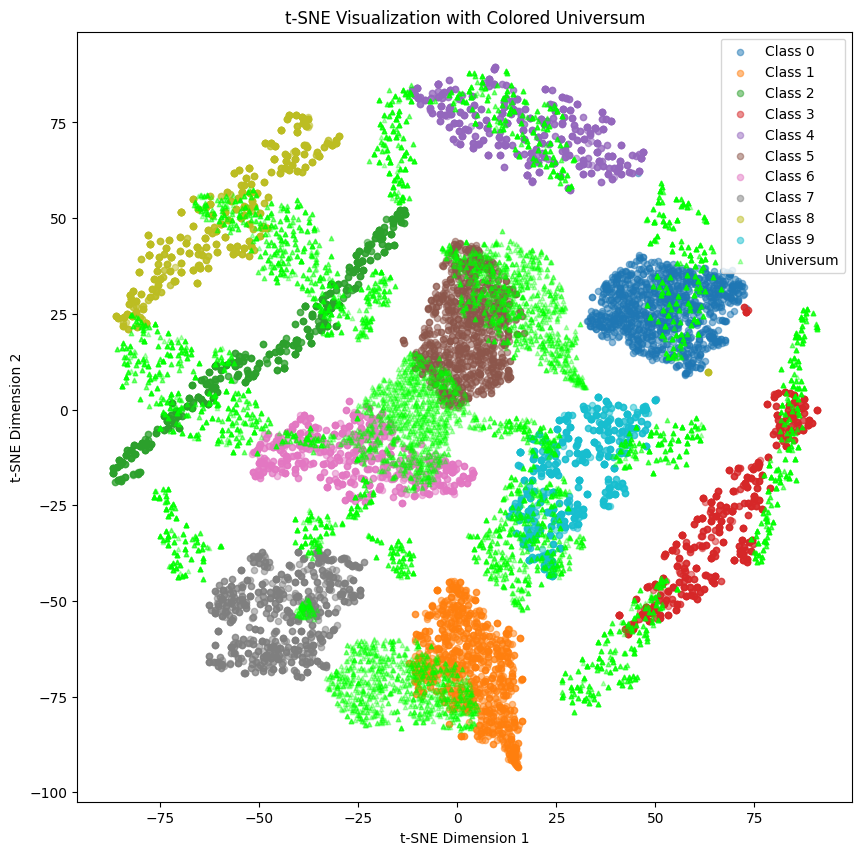

In [52]:
plot_tsne_with_colored_universum(new_embs, total_label[indices], universum_tsne, universum_colors, n_classes)